In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from collections import Counter
from scipy import special
from scipy.stats import beta

from conformal_utils import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
logits = torch.load('data/imagenet_val/logits.pt')
labels = torch.load('data/imagenet_val/labels.pt')

# Convert to Numpy arrays
logits = logits.numpy()
labels = labels.type(torch.LongTensor).numpy()

### Some sanity checks

In [4]:
logits.shape

(50000, 1000)

In [22]:
labels.shape

(50000,)

In [6]:
min(labels), max(labels)

(0, 999)

In [7]:
# Check that there are 50 instances of each class
Counter(labels)

Counter({828: 50,
         800: 50,
         998: 50,
         782: 50,
         570: 50,
         900: 50,
         164: 50,
         776: 50,
         303: 50,
         967: 50,
         81: 50,
         779: 50,
         520: 50,
         441: 50,
         563: 50,
         849: 50,
         197: 50,
         885: 50,
         275: 50,
         615: 50,
         265: 50,
         196: 50,
         826: 50,
         464: 50,
         569: 50,
         131: 50,
         618: 50,
         969: 50,
         578: 50,
         507: 50,
         624: 50,
         510: 50,
         427: 50,
         997: 50,
         455: 50,
         2: 50,
         841: 50,
         866: 50,
         633: 50,
         973: 50,
         18: 50,
         613: 50,
         953: 50,
         202: 50,
         126: 50,
         596: 50,
         774: 50,
         302: 50,
         812: 50,
         96: 50,
         213: 50,
         860: 50,
         711: 50,
         516: 50,
         592: 50,
         314: 5

# Exploratory analysis

Use 5,000 instances as calibration and the remaining 45,000 as validation

1. Perform standard conformal inference and evaluate coverage
2. Perform class-balanced conformal inference and evaluate coverage


In [8]:
alpha = .1

In [9]:
np.random.seed(0)

# Convert logits to softmax vectors
softmax_scores = special.softmax(logits, axis=1)
scores = 1 - softmax_scores

# ======== SHUFFLE AND SPLIT DATA ======== 
num_calib = 25000
idx = np.random.permutation(np.arange(len(labels)))
shuffled_logits = scores[idx]
shuffled_labels = labels[idx]
calib_scores, calib_labels = scores[:num_calib], labels[:num_calib]
val_scores, val_labels = scores[num_calib:], labels[num_calib:]

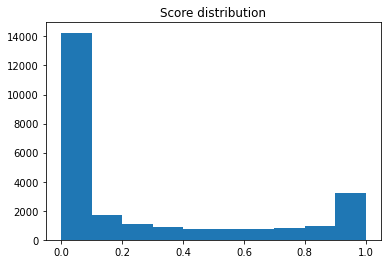

qhat: 0.9504131871128082
Standard conformal inference "marginal coverage": 89.69%


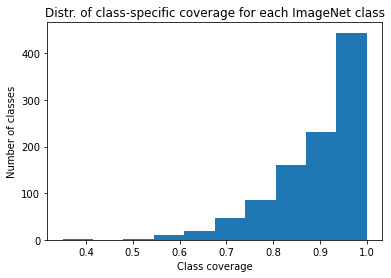

In [10]:
# ======== STANDARD CONFORMAL INFERENCE ======== 
# --- Get confidence sets ---
standard_ci_qhat = compute_qhat(calib_scores, calib_labels, alpha=alpha, plot_scores=True)
print('qhat:', standard_ci_qhat)
standard_ci_preds = create_prediction_sets(val_scores, standard_ci_qhat)

# --- Evaluate confidence sets ---
# i) Marginal coverage
marginal_cov = compute_coverage(val_labels, standard_ci_preds)
print(f'Standard conformal inference "marginal coverage": {marginal_cov*100:.2f}%')
# ii) Class-specific coverage
class_specific_cov = compute_class_specific_coverage(val_labels, standard_ci_preds)
# print(f'Standard conformal inference "class specific coverage": {class_specific_cov}')
plt.hist(class_specific_cov)
plt.xlabel('Class coverage')
plt.ylabel('Number of classes')
plt.title('Distr. of class-specific coverage for each ImageNet class')
plt.show()

One problem I am running into is that some classes do not appear in the calibration dataset or appear only a few times, which makes $\frac{\lceil(n+1)(1-\alpha)\rceil}{n} \geq 1$, which is not a valid quantile! I'm not sure what is the best approach for dealing with those classes. One option is to just use the non-class-specific quantile obtained from standard conformal inference. Another option is to set the quantile to $\infty$

Class-balanced conformal inference "marginal coverage": 92.13%


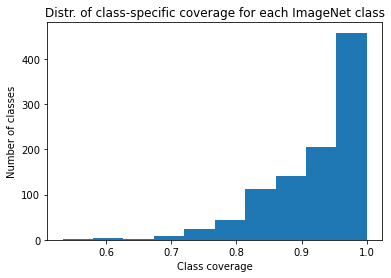

In [11]:
# ======== CLASS-BALANCED CONFORMAL INFERENCE ======== 
# --- Get confidence sets ---
default_qhat = standard_ci_qhat
qhats = compute_class_specific_qhats(calib_scores, calib_labels, alpha=alpha, default_qhat=np.inf)
# print('qhats:', qhats)
class_balanced_ci_preds = create_cb_prediction_sets(val_scores, qhats)

# --- Evaluate confidence sets ---
# i) Marginal coverage
cb_marginal_cov = compute_coverage(val_labels, class_balanced_ci_preds)
print(f'Class-balanced conformal inference "marginal coverage": {cb_marginal_cov*100:.2f}%')
# ii) Class-specific coverage
cb_class_specific_cov = compute_class_specific_coverage(val_labels, class_balanced_ci_preds)
# print(f'Standard conformal inference "class specific coverage": {class_specific_cov}')
plt.hist(cb_class_specific_cov)
plt.xlabel('Class coverage')
plt.ylabel('Number of classes')
plt.title('Distr. of class-specific coverage for each ImageNet class')
plt.show()

In [12]:
# plt.hist(calib_scores[2])

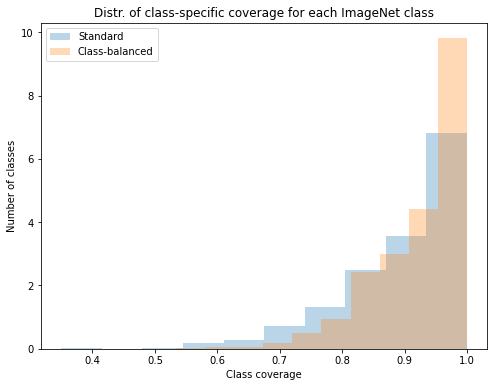

In [21]:
## Plot
plt.figure(figsize=(8,6))

# Combine histograms into one plot
plt.hist(class_specific_cov, label="Standard", alpha=.3, density=True)
plt.hist(cb_class_specific_cov, label="Class-balanced", alpha=.3, density=True)

# TODO: Fix this
# # Plot analytical distribution if we assume 
# #  (1) We have an infinite amount of validation data
# #  (2) The calibration set contains an equal number of each class [Note: I'm still working on deriving the distribution when we relax this assumption]
# # (Copied from Anastasios' code in correctness-checks.ipynb, which is linked to in Gentle Intro Section 3)
# n = num_calib / 1000 # This is where Assumption 2 is used
# l = np.floor((n+1)*alpha)
# a = n + 1 - l
# b = l
# rv = beta(a, b)
# x = np.linspace(0.4,1,1000)
# plt.plot(x, rv.pdf(x), lw=3, label=f'Theoretical distribution (assuming equal number of instances of each class)')


# Label plot
plt.xlabel('Class coverage')
plt.ylabel('Number of classes')
plt.title('Distr. of class-specific coverage for each ImageNet class')
plt.legend(loc='upper left')
plt.show()

In [ ]:
np.mean(class_specific_cov)

In [ ]:
np.mean(cb_class_specific_cov)

In [ ]:
class_balanced_ci_preds

In [ ]:
standard_ci_preds

We now create an 1000 x 2 array where row i = [# of times class i appears in validation set, # of times class i is included to conformal set prediction when class i is true label]. Note that the second element is equal to (# of times class i appears in validation set)*(observed class coverage under standard conformal inference).

This array will be fed into the `deconvolveR` package to estimate the distribution of class coverage under standard conformal inference

In [30]:
# Count the number of instances of each class in the validation set
class_cts = Counter(val_labels)

# Create array
X = np.zeros((1000,2))
for i in range(len(X)):
    X[i,:] = [class_cts[i], class_cts[i]*cb_class_specific_cov[i]]
    
# Save array
save_to = "data/standard_conformal_class_coverage.csv"
np.savetxt(save_to, X, delimiter=",")
print(f'Saved array to {save_to}')

Saved array to data/standard_conformal_class_coverage.csv
